In [1]:
import pandas as pd
import numpy as np
import os
import time
from tqdm.notebook import tqdm

In [2]:
# import re
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

In [3]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [5]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
if os.getcwd()[0]=='C':
    drivepath = os.getcwd()
else:
    drivepath = '/content/drive/MyDrive/Colab Notebooks'

In [7]:
### Import papers dataframe in HDF5 file
filename = 'papers_abstract.h5'
filepath = os.path.join(drivepath, filename)

df_papers = pd.read_hdf(filepath, key = 'df_papers')
df_papers.head(3)

,Paper Title,Year,Author,Publication,Url of paper,Abstract
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...,Conventional image analysis hardware was used ...
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...,There are two contributions to this work:(i)Fe...
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...,"In the field of defect detection, image proces..."


array([[<AxesSubplot:title={'center':'Year'}>]], dtype=object)

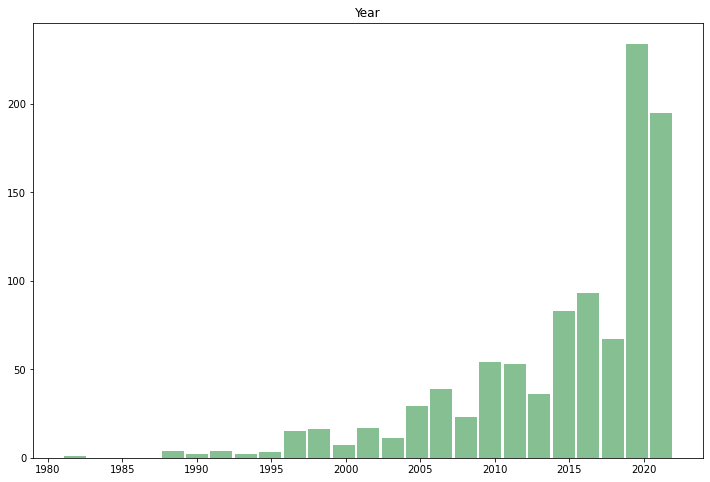

In [8]:
df_papers.hist(column='Year', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9) #, title="Papers vs Years"

### Text Pre-Processing

In [9]:
### Cleaning the rows not completly filled
df_papers = df_papers.dropna()

In [10]:
text_id = 1 ### id of the text to print to see if preprocesing is working well

texts = df_papers['Abstract'].values.tolist()

print("Original document:")
print(texts[text_id])

Original document:
There are two contributions to this work:(i)Feature Pyramid Network (FPN) and RoIAlign are adopted to improve the detection accuracy in X-ray image defect detection.(ii)The mean of Average Precision (mAP) value exists an optimal value instead of continuously increasing with the number of dataset rising in different data augmentation method.AbstractNondestructive testing (NDT) for casting aluminum parts is an essential quality management procedure. In order to avoid the effects of human fatigue and improve detection accuracy, intelligent visual inspection systems are adopted on production lines. Conventional methods of defect detection can require heavy image pre-processing and feature extraction. This paper proposes a defect detection system based on X-ray oriented deep learning, which focuses on approaches that improve the detection accuracy at both the algorithm and data augmentation levels. Feature Pyramid Network (FPN) was primarily adopted for algorithm modifica

#### - Lowering the texts

In [11]:
### lowering all the char of the text
texts = [t.lower() for t in texts]

#### - Tokenize words and Clean-up text

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

texts_words = list(sent_to_words(texts))

print("After tokenization with Gensim:")
print(texts_words[text_id])

After tokenization with Gensim:
['there', 'are', 'two', 'contributions', 'to', 'this', 'work', 'feature', 'pyramid', 'network', 'fpn', 'and', 'roialign', 'are', 'adopted', 'to', 'improve', 'the', 'detection', 'accuracy', 'in', 'ray', 'image', 'defect', 'detection', 'ii', 'the', 'mean', 'of', 'average', 'precision', 'map', 'value', 'exists', 'an', 'optimal', 'value', 'instead', 'of', 'continuously', 'increasing', 'with', 'the', 'number', 'of', 'dataset', 'rising', 'in', 'different', 'data', 'augmentation', 'method', 'testing', 'ndt', 'for', 'casting', 'aluminum', 'parts', 'is', 'an', 'essential', 'quality', 'management', 'procedure', 'in', 'order', 'to', 'avoid', 'the', 'effects', 'of', 'human', 'fatigue', 'and', 'improve', 'detection', 'accuracy', 'intelligent', 'visual', 'inspection', 'systems', 'are', 'adopted', 'on', 'production', 'lines', 'conventional', 'methods', 'of', 'defect', 'detection', 'can', 'require', 'heavy', 'image', 'pre', 'processing', 'and', 'feature', 'extraction', 

#### - Remove Stop Words

In [13]:
stop_words = list(STOP_WORDS)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# print("Stop Words:")
# print(stop_words)

In [14]:
# remove stop words
texts_words = remove_stopwords(texts_words)

print("After removing Stop Words:")
print(texts_words[text_id])

After removing Stop Words:
['contributions', 'work', 'feature', 'pyramid', 'network', 'fpn', 'roialign', 'adopted', 'improve', 'detection', 'accuracy', 'ray', 'image', 'defect', 'detection', 'ii', 'mean', 'average', 'precision', 'map', 'value', 'exists', 'optimal', 'value', 'instead', 'continuously', 'increasing', 'number', 'dataset', 'rising', 'different', 'data', 'augmentation', 'method', 'testing', 'ndt', 'casting', 'aluminum', 'parts', 'essential', 'quality', 'management', 'procedure', 'order', 'avoid', 'effects', 'human', 'fatigue', 'improve', 'detection', 'accuracy', 'intelligent', 'visual', 'inspection', 'systems', 'adopted', 'production', 'lines', 'conventional', 'methods', 'defect', 'detection', 'require', 'heavy', 'image', 'pre', 'processing', 'feature', 'extraction', 'paper', 'proposes', 'defect', 'detection', 'system', 'based', 'ray', 'oriented', 'deep', 'learning', 'focuses', 'approaches', 'improve', 'detection', 'accuracy', 'algorithm', 'data', 'augmentation', 'levels', '

#### - Bigram & Trigram

In [15]:
# # Build the bigram and trigram models
# bigram = gensim.models.Phrases(texts_words, min_count=5, threshold=10) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[texts_words], threshold=10)  

# # Faster way to get a sentence clubbed as a trigram/bigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# # # See trigram example
# # print(trigram_mod[bigram_mod[texts_words[text_id]]])

In [16]:
# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [17]:
# # Form Bigrams
# texts_words = make_bigrams(texts_words)

#### - Lemmatizing

In [18]:
nlp = spacy.load("en_core_web_lg")

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    results = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        results.append([word.lemma_ for word in doc if word.pos_ in allowed_postags])
    return results

In [19]:
# lemmatizing
# texts_words = lemmatization(texts_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
texts_words = lemmatization(texts_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print("After Lemmatization with SpaCy:")
print(texts_words[text_id])

After Lemmatization with SpaCy:
['contribution', 'work', 'feature', 'pyramid', 'network', 'roialign', 'adopt', 'improve', 'detection', 'accuracy', 'ray', 'image', 'defect', 'ii', 'mean', 'average', 'precision', 'map', 'value', 'exist', 'optimal', 'value', 'instead', 'continuously', 'increase', 'number', 'dataset', 'rise', 'different', 'datum', 'augmentation', 'method', 'test', 'cast', 'aluminum', 'part', 'essential', 'quality', 'management', 'procedure', 'order', 'avoid', 'effect', 'human', 'fatigue', 'improve', 'detection', 'accuracy', 'intelligent', 'visual', 'inspection', 'system', 'adopt', 'production', 'line', 'conventional', 'method', 'defect', 'detection', 'require', 'heavy', 'image', 'pre', 'processing', 'feature', 'extraction', 'paper', 'propose', 'defect', 'detection', 'system', 'base', 'ray', 'orient', 'deep', 'learning', 'focus', 'approach', 'improve', 'detection', 'accuracy', 'algorithm', 'data', 'augmentation', 'level', 'feature', 'pyramid', 'network', 'fpn', 'primarily',

### Exploratory Analysis

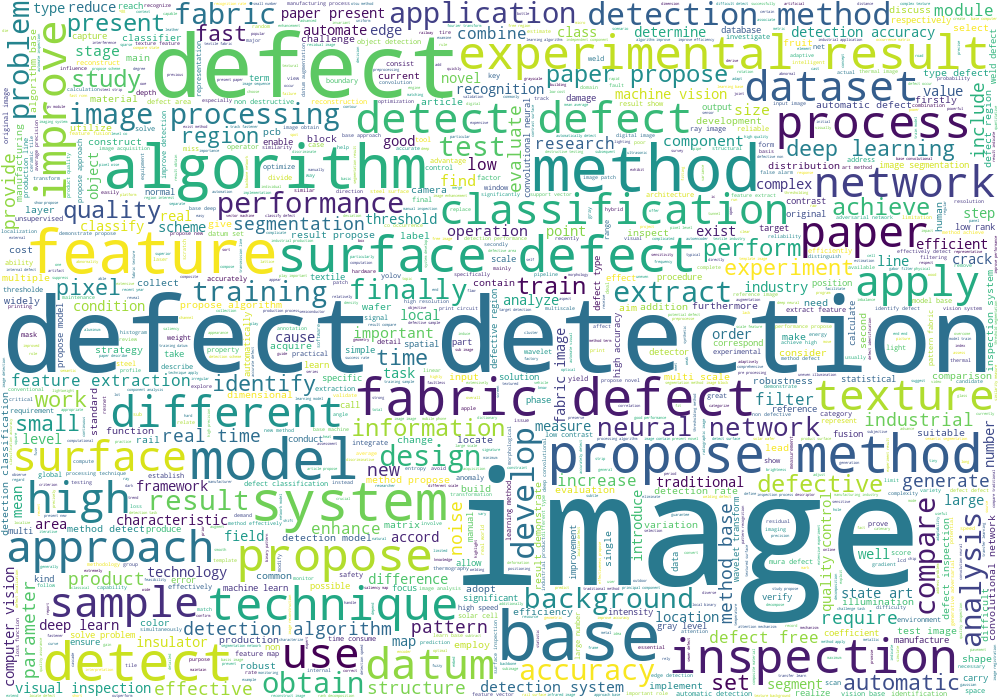

In [20]:
# Join the different processed titles together.
long_string = ','.join([' '.join(words) for words in texts_words])

# Create a WordCloud object
wc = WordCloud(background_color="white",
               width=1000, height=700,
               max_words=5000, contour_width=3,
               contour_color='steelblue')

# Generate a word cloud
wc.generate(long_string)

# Visualize the word cloud
wc.to_image()

#### - Removing DummyWords

In [21]:
#the words used in the google scholar search or word related to them that don't give much information
dummy_words = ['detect','defect','image','use','base','detection',
               'introduct','method','conclusion',
               'propose','develope','study',
               'paper','result','model', 'datum',
#                'imaging','tool',
#                'approach', 'technique',
#                'considerably','system',
#                'present','research','automate','defective','algorithm',
#                'automatic','process','processing',
#                'machine','validation','experimental','test','abnormal'
              ]

In [22]:
def remove_dummywords(texts):
    results = []
    for doc in texts:
        result = []
        for word in doc:
            if word not in dummy_words:
                result.append(word)
        results.append(result)
    
    return results

In [23]:
texts_words = remove_dummywords(texts_words)

print(texts_words[text_id])

['contribution', 'work', 'feature', 'pyramid', 'network', 'roialign', 'adopt', 'improve', 'accuracy', 'ray', 'ii', 'mean', 'average', 'precision', 'map', 'value', 'exist', 'optimal', 'value', 'instead', 'continuously', 'increase', 'number', 'dataset', 'rise', 'different', 'augmentation', 'test', 'cast', 'aluminum', 'part', 'essential', 'quality', 'management', 'procedure', 'order', 'avoid', 'effect', 'human', 'fatigue', 'improve', 'accuracy', 'intelligent', 'visual', 'inspection', 'system', 'adopt', 'production', 'line', 'conventional', 'require', 'heavy', 'pre', 'processing', 'feature', 'extraction', 'system', 'ray', 'orient', 'deep', 'learning', 'focus', 'approach', 'improve', 'accuracy', 'algorithm', 'data', 'augmentation', 'level', 'feature', 'pyramid', 'network', 'fpn', 'primarily', 'adopt', 'algorithm', 'modification', 'prove', 'well', 'suited', 'small', 'fast', 'improvement', 'mean', 'average', 'precision', 'map', 'value', 'final', 'regression', 'classification', 'stage', 'roial

In [24]:
# Join the different processed titles together.
long_string = ','.join([' '.join(words) for words in texts_words])
long_string

'conventional analysis hardware solid shade unpatteme weave fabric different software approach classify knot slub compare approach gray level statistic morphological operation autocorrelation function identify fabric structural repeat unit statistical morphological computation unit plain weave twill weave fabric compare performance software approach,contribution work feature pyramid network roialign adopt improve accuracy ray ii mean average precision map value exist optimal value instead continuously increase number dataset rise different augmentation test cast aluminum part essential quality management procedure order avoid effect human fatigue improve accuracy intelligent visual inspection system adopt production line conventional require heavy pre processing feature extraction system ray orient deep learning focus approach improve accuracy algorithm data augmentation level feature pyramid network fpn primarily adopt algorithm modification prove well suited small fast improvement me

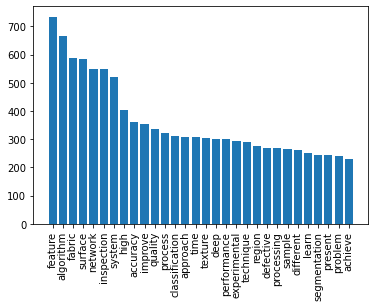

In [25]:
from collections import Counter

words_freq = Counter(long_string.split())

words_top_freq = words_freq.most_common(30)

words = [w for w, f in words_top_freq]
freq = [f for w, f in words_top_freq]

plt.bar(words, freq)
plt.xticks(rotation=90)
plt.show()

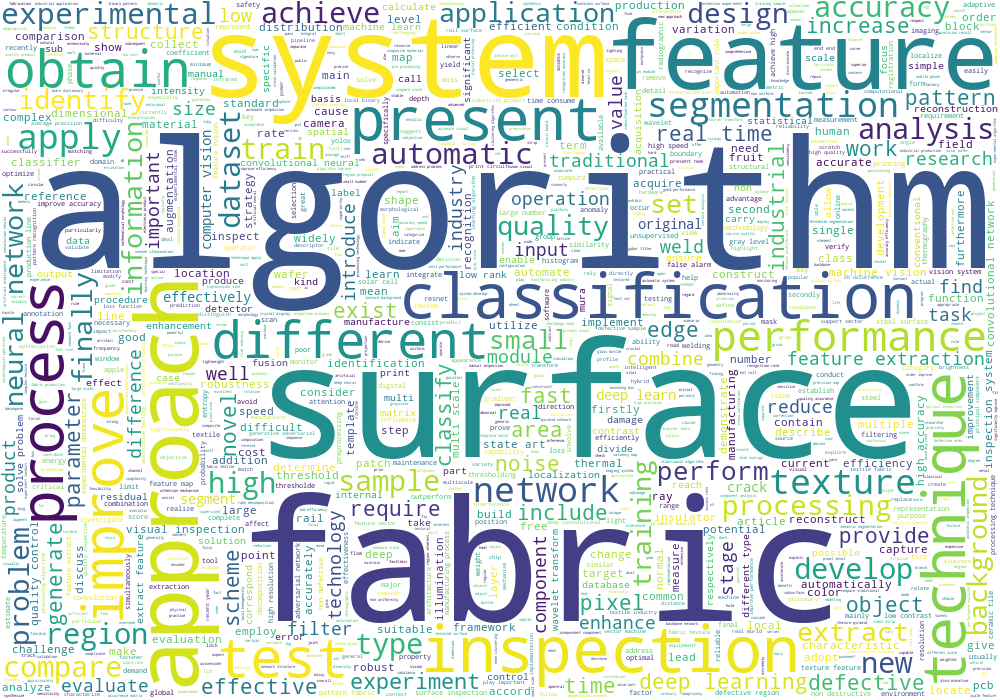

In [26]:
# Create a WordCloud object
wc = WordCloud(background_color="white",
               width=1000, height=700,
               max_words=5000, contour_width=3,
               contour_color='steelblue')

# Generate a word cloud
wc.generate(long_string)

# Visualize the word cloud
wc.to_image()

### Prepare data for LDA Analysis

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

id2word[0]

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(texts_words)

# Term Document Frequency
corpus = [id2word.doc2bow(words) for words in texts_words]

# View
print(corpus[text_id][:30])

[(1, 2), (4, 1), (6, 1), (7, 2), (14, 1), (31, 5), (32, 3), (33, 2), (34, 2), (35, 1), (36, 4), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 3), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1)]


In [28]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:text_id]]

[[('analysis', 1),
  ('approach', 3),
  ('autocorrelation', 1),
  ('classify', 1),
  ('compare', 2),
  ('computation', 1),
  ('conventional', 1),
  ('different', 1),
  ('fabric', 3),
  ('function', 1),
  ('gray', 1),
  ('hardware', 1),
  ('identify', 1),
  ('knot', 1),
  ('level', 1),
  ('morphological', 2),
  ('operation', 1),
  ('performance', 1),
  ('plain', 1),
  ('repeat', 1),
  ('shade', 1),
  ('slub', 1),
  ('software', 2),
  ('solid', 1),
  ('statistic', 1),
  ('statistical', 1),
  ('structural', 1),
  ('twill', 1),
  ('unit', 2),
  ('unpatteme', 1),
  ('weave', 3)]]

### Build LDA model

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [29]:
# number of topics
num_topics = 10

chunksize = 100
passes = 10
update_every = 1
random_state = 100

# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   update_every=update_every,
                                   num_topics=num_topics,
                                   random_state=random_state,
                                   chunksize=chunksize,
                                   passes=passes,
                                   per_word_topics=True)

# Print the Keyword
[ print(t) for t in lda_model.print_topics()]

doc_lda = lda_model[corpus]

(0, '0.020*"inspection" + 0.016*"approach" + 0.015*"technique" + 0.014*"pattern" + 0.010*"machine" + 0.010*"system" + 0.008*"surface" + 0.008*"apply" + 0.008*"research" + 0.007*"analysis"')
(1, '0.068*"fabric" + 0.033*"texture" + 0.019*"feature" + 0.015*"filter" + 0.014*"algorithm" + 0.013*"wavelet" + 0.013*"textile" + 0.012*"defective" + 0.012*"pattern" + 0.011*"low"')
(2, '0.025*"module" + 0.022*"thermal" + 0.021*"insulator" + 0.019*"component" + 0.018*"thermography" + 0.016*"mura" + 0.014*"signal" + 0.011*"analysis" + 0.011*"pv" + 0.011*"testing"')
(3, '0.034*"system" + 0.031*"inspection" + 0.021*"quality" + 0.018*"time" + 0.013*"process" + 0.013*"processing" + 0.012*"present" + 0.012*"product" + 0.011*"vision" + 0.010*"manufacturing"')
(4, '0.036*"target" + 0.035*"feature" + 0.021*"algorithm" + 0.021*"secondly" + 0.018*"equipment" + 0.017*"semantic" + 0.016*"extract" + 0.014*"machine" + 0.013*"selection" + 0.013*"accuracy"')
(5, '0.033*"algorithm" + 0.021*"surface" + 0.014*"feature

#### - Compute Perplexity & Coherence Score

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=texts_words,
                                     dictionary=id2word,
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.387305283753908

Coherence Score:  0.35921909125929086


#### - Optimize #Topics

 class gensim.models.ldamodel.LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>)

In [31]:
def calculate_coherence_score(n, coherence='u_mass'):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=random_state,
                                           update_every=update_every,
                                           chunksize=chunksize,
                                           passes=passes,
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_words, dictionary=id2word, coherence=coherence)
    coherence_lda = coherence_model_lda.get_coherence()
    perplexity_lda = lda_model.log_perplexity(corpus)
    return coherence_lda, perplexity_lda

In [32]:
### List containing various hyperparameters
no_of_topics = range(2,30,1)

In [33]:
hype_scores = []

for n in tqdm(no_of_topics, desc="Topic"):
    coherence_score, perplexity_score = calculate_coherence_score(n)
    hype_scores.append([n, coherence_score, perplexity_score])
    print(f"n : {n} ; Coherence Score : {coherence_score}; Perplexity Score : {perplexity_score}")

df_hype = pd.DataFrame(hype_scores, columns=['topic','coherence','perplexity'])
df_hype

Topic:   0%|          | 0/28 [00:00<?, ?it/s]

n : 2 ; Coherence Score : -1.350878206405161; Perplexity Score : -7.1966912216042624
n : 3 ; Coherence Score : -1.4018382475835196; Perplexity Score : -7.179006585445876
n : 4 ; Coherence Score : -2.4956488621656674; Perplexity Score : -7.212171141273577
n : 5 ; Coherence Score : -2.5116846693539783; Perplexity Score : -7.203389416743348
n : 6 ; Coherence Score : -2.4707544474720016; Perplexity Score : -7.234174081601502
n : 7 ; Coherence Score : -1.9334435938977248; Perplexity Score : -7.258492934941802
n : 8 ; Coherence Score : -2.8679868920321567; Perplexity Score : -7.266536407797295
n : 9 ; Coherence Score : -4.779905786948869; Perplexity Score : -7.2910908139640505
n : 10 ; Coherence Score : -4.871309019343611; Perplexity Score : -7.387305283753908
n : 11 ; Coherence Score : -6.524701602902521; Perplexity Score : -7.54784704570059
n : 12 ; Coherence Score : -5.726594474310168; Perplexity Score : -7.825423005079596
n : 13 ; Coherence Score : -6.4610032227212395; Perplexity Score :

,topic,coherence,perplexity
0,2,-1.350878,-7.196691
1,3,-1.401838,-7.179007
2,4,-2.495649,-7.212171
3,5,-2.511685,-7.203389
4,6,-2.470754,-7.234174
5,7,-1.933444,-7.258493
6,8,-2.867987,-7.266536
7,9,-4.779906,-7.291091
8,10,-4.871309,-7.387305
9,11,-6.524702,-7.547847


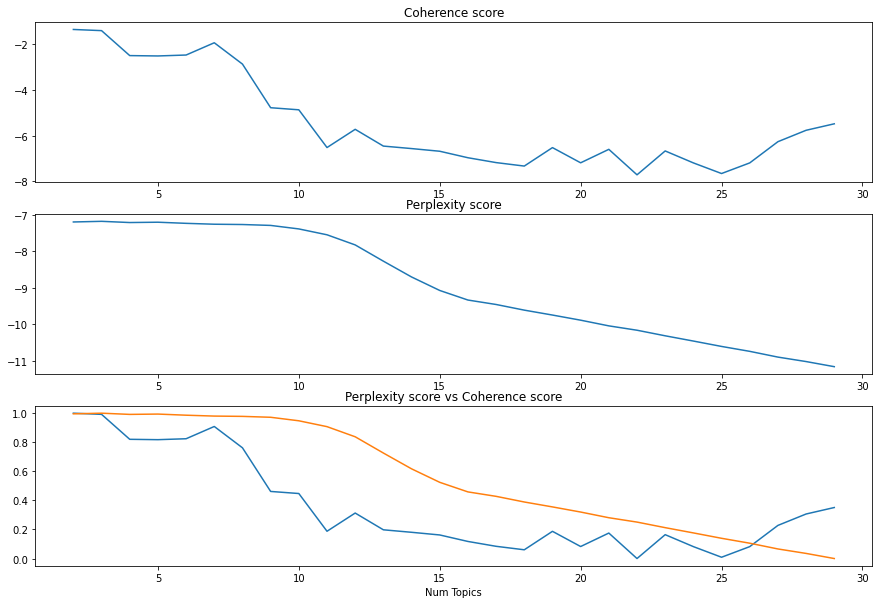

In [117]:
# Show graph
x = no_of_topics


fig, axs =  plt.subplots(3)

fig.set_figheight(10)
fig.set_figwidth(15)
    
y_c = df_hype['coherence']
axs[0].set_title('Coherence score')
axs[0].plot(x, y_c)

y_p = df_hype['perplexity']
axs[1].set_title('Perplexity score')
axs[1].plot(x, y_p)

axs[2].set_title('Perplexity score vs Coherence score')
axs[2].plot(x, (y_c-min(y_c))/(max(y_c)-min(y_c)))
axs[2].plot(x,(y_p-min(y_p))/(max(y_p)-min(y_p)))


plt.xlabel("Num Topics")
plt.show()

In [118]:
filename = 'hyperparameters_opt.csv'
filepath = os.path.join(drivepath, filename)
df_hype.to_csv(filepath, mode='w', sep=';', index=False, header=True)

df_hype

,topic,coherence,perplexity
0,2,-1.350878,-7.196691
1,3,-1.401838,-7.179007
2,4,-2.495649,-7.212171
3,5,-2.511685,-7.203389
4,6,-2.470754,-7.234174
5,7,-1.933444,-7.258493
6,8,-2.867987,-7.266536
7,9,-4.779906,-7.291091
8,10,-4.871309,-7.387305
9,11,-6.524702,-7.547847


#### - Optimal LDA model(best topics number)

In [124]:
n_best = 11


In [125]:
optimal_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       update_every=update_every,
                                       num_topics=n_best,
                                       random_state=random_state,
                                       chunksize=chunksize,
                                       passes=passes,
                                       per_word_topics=True)


In [126]:
# Print the Optimal Keyword in the topics
[ print(t) for t in optimal_model.print_topics()]

doc_lda = optimal_model[corpus]

(0, '0.030*"inspection" + 0.023*"system" + 0.017*"technique" + 0.015*"approach" + 0.013*"present" + 0.010*"process" + 0.010*"time" + 0.010*"quality" + 0.010*"processing" + 0.009*"analysis"')
(1, '0.075*"fabric" + 0.036*"texture" + 0.021*"feature" + 0.017*"algorithm" + 0.016*"pattern" + 0.015*"filter" + 0.014*"matrix" + 0.014*"textile" + 0.012*"low" + 0.011*"block"')
(2, '0.024*"insulator" + 0.021*"thermal" + 0.021*"thermography" + 0.016*"high" + 0.015*"phase" + 0.014*"component" + 0.014*"optical" + 0.013*"signal" + 0.012*"analysis" + 0.011*"environment"')
(3, '0.045*"sewer" + 0.034*"pipe" + 0.023*"pipeline" + 0.019*"tunnel" + 0.019*"ultrasonic" + 0.019*"condition" + 0.016*"building" + 0.016*"author" + 0.015*"rope" + 0.015*"validation"')
(4, '0.027*"deep" + 0.019*"learning" + 0.019*"accuracy" + 0.018*"learn" + 0.017*"network" + 0.013*"surface" + 0.012*"improve" + 0.012*"algorithm" + 0.011*"quality" + 0.010*"classification"')
(5, '0.033*"algorithm" + 0.025*"surface" + 0.014*"region" + 0.

### Analyzing LDA model results

#### - Finding the dominant topic in each sentence

In [101]:
# def format_topics_sentences(ldamodel, corpus, texts):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row in enumerate(corpus):
#         row = ldamodel.get_document_topics(bow=row,minimum_probability=0)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
#     return(sent_topics_df)

In [108]:
# df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts_words)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # Show
# df_dominant_topic

#### - Find the most representative document for each topic

In [109]:
# # Group top 5 sentences under each topic
# sent_topics_sorteddf_lda = pd.DataFrame()

# sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

# for i, grp in sent_topics_outdf_grpd:
#     sent_topics_sorteddf_lda = pd.concat([sent_topics_sorteddf_lda, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# # Reset Index    
# sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# # Format
# sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# # Show
# sent_topics_sorteddf_lda

#### -  Topic distribution across documents

In [42]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics

#### - Visual Topics distribution

In [127]:
LDAvis_prepared = gensimvis.prepare(optimal_model, corpus, id2word)
LDAvis_prepared

C:\Users\carmi\anaconda3\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.155567 -0.132124       1        1  22.424646
5     -0.203529 -0.011198       2        1  18.679053
6     -0.212039  0.114377       3        1  17.025681
4     -0.200152 -0.041932       4        1  15.523747
1     -0.158479  0.144989       5        1  11.463762
2      0.082578 -0.279362       6        1   4.570946
7      0.099624  0.035478       7        1   3.270386
8      0.151713 -0.028493       8        1   2.420857
9      0.185764  0.043842       9        1   2.192700
3      0.214509  0.080040      10        1   1.565684
10     0.195578  0.074383      11        1   0.862539, topic_info=            Term        Freq       Total Category  logprob  loglift
8         fabric  566.000000  566.000000  Default  30.0000  30.0000
82       network  589.000000  589.000000  Default  29.0000  29.0000
108       system  510.000000  510.000000  Default  28.0000  28.0000
284      texture  300.000000  300.000000  Default  27.0000  27.0000
71    inspection  564.000000  564.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2607  undecimate    1.254412    2.082275  Topic11  -6.1180   4.2463
534    transform   33.365622   82.132594  Topic11  -2.8372   3.8522
1185     degrade    3.733010    9.278594  Topic11  -5.0275   3.8425
1525      degree    4.242639   12.534888  Topic11  -4.8995   3.6697
1632      moment    1.990077   21.060462  Topic11  -5.6565   2.3938

[628 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1300      5  0.987039    abnormal
2721     11  0.712844  abstractin
1573      9  0.909393  accelerate
2464      8  0.844548  accomplish
115       2  0.773141      accord
...     ...       ...         ...
113       4  0.243516        work
3957      9  0.888574    workload
710       1  0.243385        year
710       4  0.730156        year
1338      3  0.990637       yolov

[1067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 7, 5, 2, 3, 8, 9, 10, 4, 11])

Topic 0


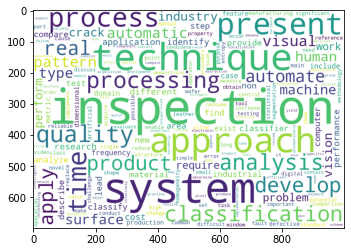

Topic 1


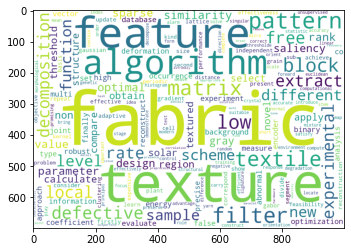

Topic 2


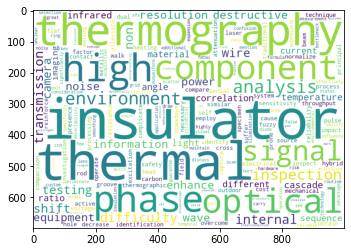

Topic 3


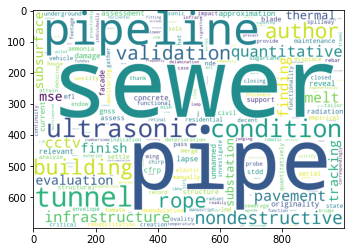

Topic 4


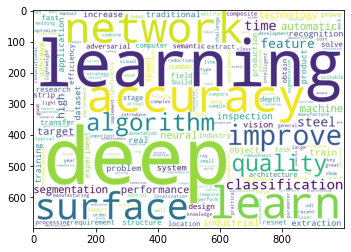

Topic 5


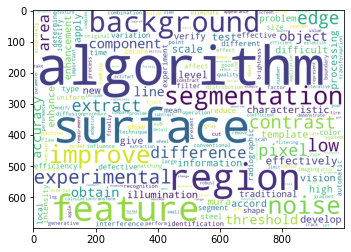

Topic 6


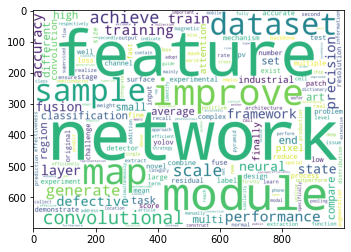

Topic 7


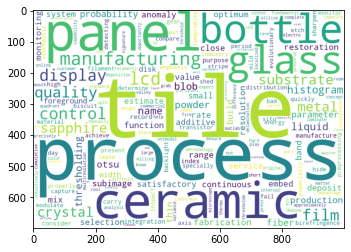

Topic 8


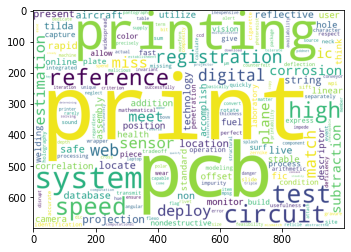

Topic 9


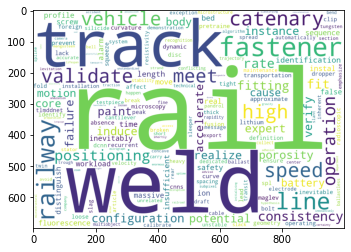

Topic 10


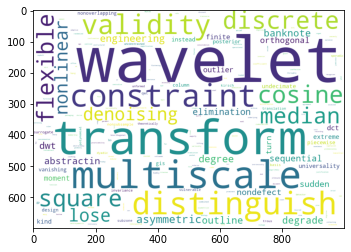

In [128]:
wc = WordCloud(background_color="white", 
               width=1000, height=700, 
               contour_width=3, 
               contour_color='steelblue')
    
for t in range(n_best):
    print("Topic", t)
    # Generate a word cloud
    wc.fit_words(dict(optimal_model.show_topic(t, 200)))

    # Visualize the word cloud
    plt.imshow(wc)
    plt.show()